<a href="https://colab.research.google.com/github/ethanfwilliams/OOI_RCA_DAS_notebook/blob/main/OOI_RCA_OptaSense_DAS_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### About this tutorial

The goal of this tutorial is to provide an introduction to processing Distributed Acoustic Sensing (DAS) data, as well as python more generally.

The layout of the tutorial is as follows:
* DAS Overview
* Ingesting DAS data
* Processing DAS data (power spectral densities and k-$\omega$ plots)
* Making some environmental inferences from the processed DAS data 
* Validating our inferences with other available data sources:
    * HYCOM Currents (meteorological forecast)
    * NDBC Buoy Data (historic _in situ_ data)


This tutorial was significantly informed by an earlier tutorial by [Ethan Williams](https://ess.uw.edu/people/ethan-f-williams/) (currently at Univ of Washington) and the following open-access papers that informed much of the processing approach:

[Cheng, Feng, et al. "Utilizing distributed acoustic sensing and ocean bottom fiber optic cables for submarine structural characterization." Scientific reports 11.1 (2021): 5613.](https://www.nature.com/articles/s41467-024-45412-x)

[Williams, Ethan F., et al. "Distributed sensing of microseisms and teleseisms with submarine dark fibers." Nature communications 10.1 (2019): 5778.](https://www.nature.com/articles/s41467-019-13262-7)

[Trafford, Andrew, et al. "Distributed acoustic sensing for active offshore shear wave profiling." Scientific Reports 12.1 (2022): 9691.](https://www.nature.com/articles/s41598-022-13962-z)

<br>

### What is Distributed Acoustic Sensing?

Distributed acoustic sensing (DAS) is a relatively new measurement modality that captures acoustic signals via the use of very long fiber optic cables.

The mechanism behind DAS is that a laser is pulsed along a fiberoptic cable and small amounts of laser light are backscattered due to microscopic disparities throughout the fiber. This backscattered light is modulated by mechanical strain in the fiber due to acoustic fluctuations, and these signals can be extracted into time-series data. The time delay from the intial laser pulse is used to determine at what distance along the cable a fluctuation was generated. The cable is discretized into _channels_ spaced along the cable extent and each spatially separated channel records its own time-series, much like a conventional acoustic hydrophone array. 

The following figure from [Li, Jiaxuan, et al. "The break of earthquake asperities imaged by distributed acoustic sensing." Nature 620.7975 (2023): 800-806.](https://www.nature.com/articles/s41586-023-06227-w) shows a schematic of the DAS operational mechanism:

<img src='./im/das_schematic.png' width='600'>

The potential benefits of DAS vs other underwater acoustic sensing modalities is that Earth's oceans are already covered in a significant number of transcontinental fiberoptic cables originally deployed for internet and telecommunications purposes. These cables amount to billions of dollars of infrastructure that could potentially be leveraged to probe, monitor, and better understand our underwater environment.

<img src='./im/telecomm_cables_nyt.png'>

A geographic map of just some of the world's existing submarine cable infrastructure [courtesy of the New York Times](https://www.nytimes.com/interactive/2019/03/10/technology/internet-cables-oceans.html).

### Where our DAS data comes from

The Distributed Acoustic Sensing (DAS) data we're going to analyze is available through the [Ocean Observatories Initiative](https://oceanobservatories.org/pi-instrument/rapid-a-community-test-of-distributed-acoustic-sensing-on-the-ocean-observatories-initiative-regional-cabled-array/). Data are available from multiple DAS arrays in the Pacific Northwest (near Portland), though we'll be looking at data from an Optasense DAS system.

The laydown for the OOI DAS systems is shown below. We'll be looking at data from the __North Cable__. The data for this array are available in 60 second time snippets ranging from ~06:30-09:00 EST (14:30-17:00 UTC, aka "Z" or "Zulu" Time).

<img src='./im/das_laydown.jpg' width='1000'>


In [1]:
# Users may need to install the following nonstandard libraries:

# !pip install h5py
# !pip install scipy
# !pip install pandas
# !pip install matplotlib
# !pip install cmocean

# print('Done!')

In [2]:
# Import standard libraries
import urllib.request               # For downloading the DAS data directly from the OOI page
import h5py                         # For importing data from HDF5 files (including NetCDF4 files)
import numpy as np                  # For array operations
import scipy.signal as sp           # For data signal processing
import matplotlib.pyplot as plt     # For plotting
from matplotlib import cm, colors   # For colormaps
import cmocean                      # For prettier colormaps
import pandas as pd                 # For ingesting data from text, cs, etc. files
import datetime as dt               # For dealing with dates
import pickle                       # For saving out / loading in python data for this tutorial

### Downloading and Ingesting DAS data (from an HDF5 file)

We will download the DAS data directly from the OOI portal. The raw data can be downloaded as an HDF5 file from [this page](http://piweb.ooirsn.uw.edu/das/data/Optasense/NorthCable/ReceiveFiber/North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz-ReceiveFiber_2021-11-05T07_31_00-0700/), but __caution__, each 60 second file is about __800 MB__ in size! DAS can be a very storage intensive sensing modality. We will only download the first file from the fileset.

The [Hierarchical Data Format 5 (HDF5)](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) is a very convenient data format because it's simple, open-source, and has libraries for pretty much all common languages. Also, NetCDF4 is based on HDF5 and so most HDF5 readers also work for NetCDF4 data files (as we'll see later in this tutorial).

We'll use the `h5py` library to ingest our data. Ultimately we're gonna end up with an object that has folder/file type structure where folders are known as "Groups" and files are known as "Attributes", where an attribute can be a string, number, array, etc. "Keys" are simply python's nomenclature for the names of the Groups and/or Attributes (analogous to "fieldnames" for MATLAB structures). 
<br><br>

In [3]:
# Download the DAS Data file
url = 'http://piweb.ooirsn.uw.edu/das/data/Optasense/NorthCable/ReceiveFiber/North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz-ReceiveFiber_2021-11-05T07_31_00-0700/North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz-ReceiveFiber_2021-11-05T143211Z.h5'
das_filename = 'North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz-ReceiveFiber_2021-11-05T143211Z.h5'

urllib.request.urlretrieve(url,das_filename)

('North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz-ReceiveFiber_2021-11-05T143211Z.h5',
 <http.client.HTTPMessage at 0x1f8761f8190>)

In [4]:
# Load the DAS Data file
das_filename = './North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz-ReceiveFiber_2021-11-05T143211Z.h5'
das_file = h5py.File(das_filename,'r')

# Print out the "keys" (aka "groups") at the highest level of the HDF5 file
print(das_file.keys())

<KeysViewHDF5 ['Acquisition']>


<br>
The top-level group in our HDF5 file is a named "Acquisition". We can print the metadata attributes associated with the "Acquisition" group. Here we can obtain some basic information about the acquisition including the gauge length, pulse rate, and spatial sampling interval.
<br><br>

In [5]:
# Print the attributes for "Acquisition"
print(das_file['Acquisition'].attrs.keys())

# Print the values associated with some important attributes
print('\nThe system gauge length is: ',das_file['Acquisition'].attrs['GaugeLength'],'m.')
print('The system pulse rate is: ',das_file['Acquisition'].attrs['PulseRate'],'Hz.')
print('The spatial sampling interval of the system is: ',das_file['Acquisition'].attrs['SpatialSamplingInterval'],'m.')

<KeysViewHDF5 ['AcquisitionId', 'GaugeLength', 'GaugeLengthUnit', 'MaximumFrequency', 'MinimumFrequency', 'NumberOfLoci', 'PulseRate', 'PulseWidth', 'PulseWidthUnit', 'SpatialSamplingInterval', 'SpatialSamplingIntervalUnit', 'StartLocusIndex', 'TriggeredMeasurement', 'VendorCode', 'schemaVersion', 'uuid']>

The system gauge length is:  51.04762 m.
The system pulse rate is:  1000.0 Hz.
The spatial sampling interval of the system is:  2.0419047 m.


<br>

The "Acquisition" group itself has two subgroups:
* "Custom"
* "Raw\[0\]"

The "Custom" group has attributes that document settings & parameters of the DAS system and modem, such as whether the GPS clock was synced, whether decimation was applied to the streaming data, and the nominal value of fiber refractive index used to convert pulse return time into distance. There are no further subgroups within "Custom" (you can check yourself with `das_file['Acquisition']['Custom'].keys()`). You can also display all of the available attributes within the "Custom" group with `das_file['Acquisition']['Custom'].attrs.keys()`. 

The second group "Raw\[0\]" is a container for three more groups: 
* "Custom" (not the same as above)
* "RawDataTime"
* "RawData"

The first of these, "Custom" contains some additional system diagnostics that we don't need. The second, "RawDataTime", is a dataset containing the UTC timestamp for each sample in the file in units of microseconds. The third, "RawData", is the actual data we seek.
<br><br>

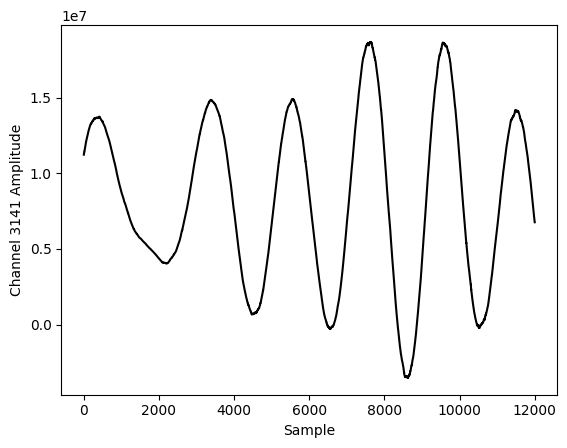

In [6]:
# Create a new variable for the "RawData" h5py dataset
raw_data = das_file['Acquisition']['Raw[0]']['RawData']

# Get the data for an arbitrary channel
channelIdx = 3141
channelData = raw_data[channelIdx,:]

# Plot raw (unnormalized) channel data
plt.figure
plt.plot(channelData,'k')
plt.xlabel('Sample')
plt.ylabel(f'Channel {channelIdx} Amplitude');

There are two important points to notice here: 
* The amplitude of the raw data is not in units of strain. Rather, it is still in units of unwrapped optical phase (radians multiplied by a constant). 
* The average value is large because the phase is tracked from the start of the DAS system and drifts over long time periods due to temperature effects for each channel indepently. We will have to remove the mean (constant detrend) to compare adjacent channels later.

The units are given in the attribute `datafile['Acquisition']['Raw[0]'].attrs['RawDataUnit']`. In order to convert these to strain, we first remove the constant factor to return units of radians, and then we apply the following formula:

\begin{equation}
    \varepsilon = \frac{1550 \times 10^{-9}}{0.79 \times 4 \pi \times n \times L} \Delta\Phi
\end{equation}

Here 1550e-9 is the wavelength in meters and $L$ is the gauge length in meters, so the result is in units of strain. $n$ is the fiber's index of refraction - a typical value is 1.46, but we can use the value stored in the metdata at `fp['Acquisition']['Custom'].attrs['Fibre Refractive Index']` as a nominal value for $n$. The factor of 0.79 is the [Pockels Coefficient](https://en.wikipedia.org/wiki/Pockels_effect) that relates a fiber's index of refraction to the electric field applied to it. For a deeper dive into the theory of DAS measurements check out [Lindsey et al. (2020)](https://doi.org/10.1029/2019JB018145) or [Lindsey & Martin (2021)](https://doi.org/10.1146/annurev-earth-072420-065213).

The following code block aggregates the DAS data into a python dictionary that conveniently contains all of the named variables that we'll needlater in place.
<br><br>

In [7]:
# Define a dictionary to contain all of the important DAS parameters
dasParameters = {
    'Wavelength': das_file['Acquisition']['Custom'].attrs['Fibre Refractive Index'],
    'GaugeLength': das_file['Acquisition'].attrs['GaugeLength'],
    'RefractiveIndex': das_file['Acquisition']['Custom'].attrs['Fibre Refractive Index'],
    'PockelsCoefficient': 0.79
}
dasParameters['StrainScaleFactor'] =  (1550*1e-9)/(dasParameters['PockelsCoefficient'] * 4*np.pi * dasParameters['RefractiveIndex'] * dasParameters['GaugeLength']) * (2*np.pi)/2**16

sample_rate = das_file['Acquisition']['Raw[0]'].attrs['OutputDataRate']
channel_spacing = das_file['Acquisition'].attrs['SpatialSamplingInterval']
num_sample = das_file['Acquisition']['Raw[0]']['RawDataTime'].attrs['Count']
num_channel = das_file['Acquisition']['Raw[0]'].attrs['NumberOfLoci']

# Define a dictionary to contain all of the DAS data, in addition to the DAS parameters as a sub-item
das = {
    'SampleRate': sample_rate,
    'ChannelSpacing': channel_spacing,
    'NumberSamples': num_sample,
    'NumberChannels': num_channel,
    'Time': np.arange(num_sample)/sample_rate,
    'Distance': np.arange(num_channel)*channel_spacing,
    'Strain': raw_data * dasParameters['StrainScaleFactor'],
    'DasParameters': dasParameters
}

# In practice, it's good to delete large variables that we no longer need
# del raw_data

### Analyzing DAS data

With DAS data ingested and propoerly converted to physical units of strain, let's do some analysis!

First, lets plot the time series for a few of the channels and compute/plot their power spectra.

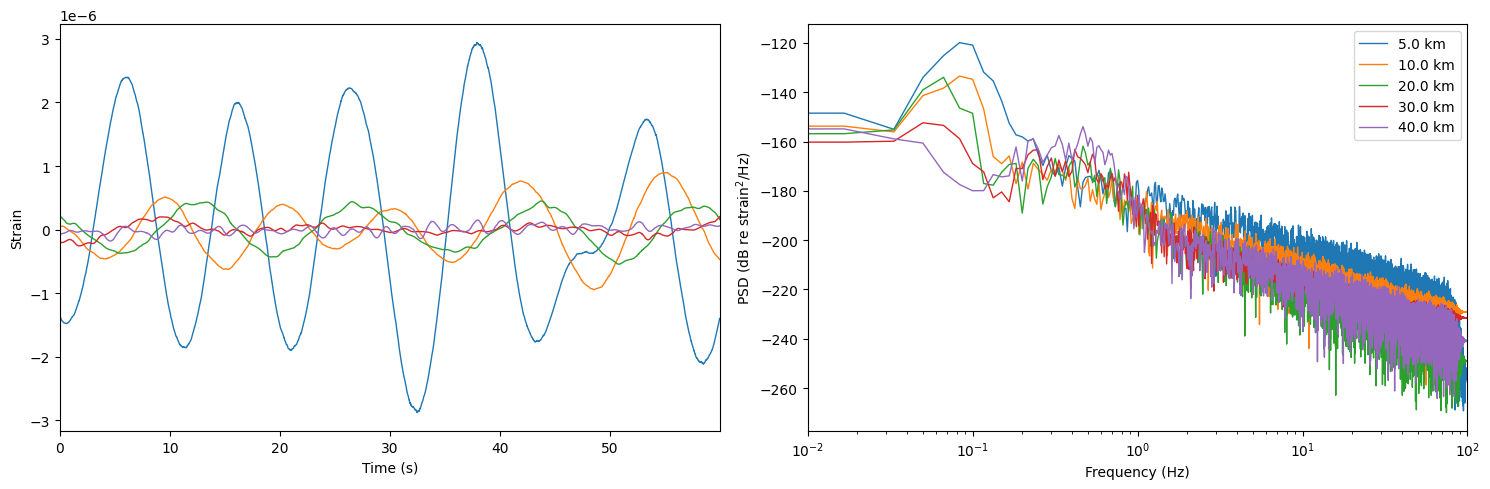

In [8]:
# Define a frequency vector to plot against
f = np.fft.rfftfreq(das['NumberSamples'],d=1./das['SampleRate'])                               # Hz

# Calculate and plot the spectrum for a few channels
channel_range = [5000,10000,20000,30000,40000]                                                 # m, along cable
fig,ax = plt.subplots(1,2,figsize=(15,5))
for inc in channel_range:
    channel_idx = (np.abs(das['Distance'] - inc)).argmin()                                     # get index of closest channel
    channel_data = das['Strain'][channel_idx,:]                                                # get data for this channel
    channel_data = sp.detrend(channel_data,axis=0, type='constant')                            # detrend mean value
    channel_psd = 20*np.log10( (2/das['NumberSamples']) \
                 * abs(np.fft.rfft(channel_data * sp.windows.hamming(das['NumberSamples']))) ) # compute power spectrum
    
    ax[0].plot(das['Time'],channel_data,linewidth=1.0)
    ax[1].plot(f,channel_psd,linewidth=1.0,label='%.1f km' % (das['Distance'][channel_idx]*1e-3))

# Adjust some axis properties for eaxh subplot
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Strain')
ax[0].set_xlim([np.min(das['Time']),np.max(das['Time'])])

ax[1].set_xscale('log')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('PSD (dB re strain$^2$/Hz)')
ax[1].set_xlim([1e-2,1e2])
plt.legend()
plt.tight_layout()

<br>

Even with just 60 seconds of ambient data we can immediately observe some trends. First, the channels closer to shore (smaller distance) exhibit larger strains than more distant channels. Second, some channels appear to show multiple pleaks in the frequency spectrum, one below ~0.1 Hz and the other above ~10 Hz. 

We can investigate this further by looking at data in two sets of two-dimensions:
* Space-time
* Wavenumber-Frequency (via the 2D Fourier Transform)

<br>

In [9]:
# Load in data for a subset of the array (in space and time)
xmin_m = 35000;       # m
xmax_m = 50000;       # m

tmin_s = 0;           # s
tmax_s = 60;          # s

# Compute indices for the user-defined space-time limits above
xmin_idx = (np.abs(das['Distance'] - xmin_m)).argmin()
xmax_idx = (np.abs(das['Distance'] - xmax_m)).argmin()
tmin_idx = (np.abs(das['Time'] - tmin_s)).argmin()
tmax_idx = (np.abs(das['Time'] - tmax_s)).argmin()

# Downsample the in range and/or time to speed up the calculations and plots
# In practice, a lowpass filter should be applied beforehand to avoid aliasing
delx = 10
delt = 1

samplerate_space = 1/(das['ChannelSpacing']*delx)
samplerate_time = das['SampleRate']/delt

strain = das['Strain'][xmin_idx:xmax_idx:delx,tmin_idx:tmax_idx:delt]
# Dimensions of the downsampled data array
Nx = strain.shape[0]
Nt = strain.shape[1]

# Detrend the mean value from each channel
strain = sp.detrend(strain,axis=1, type='constant')

# Define new time and distance axes
time = das['Time'][tmin_idx:tmax_idx:delt]
dist = das['Distance'][xmin_idx:xmax_idx:delx]

# Define frequency and wavenumber vectors
f = np.fft.fftshift(np.fft.fftfreq(Nt,d=1/samplerate_time))
k = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(Nx,d=1/samplerate_space))

# Calculate the frequency-wavenumber spectrum
strain_ft = np.fft.fftshift(np.fft.fft2(strain))
strain_ft = strain_ft * np.sqrt(1/((samplerate_time*Nt)*(samplerate_time*Nx)))
strain_ft = 20*np.log10(abs(strain_ft))

print(f'Shape of strain array: {strain.shape}')
print(f'Shape of Fourier transformed strain array: {strain_ft.shape}')

Shape of strain array: (735, 11999)
Shape of Fourier transformed strain array: (735, 11999)


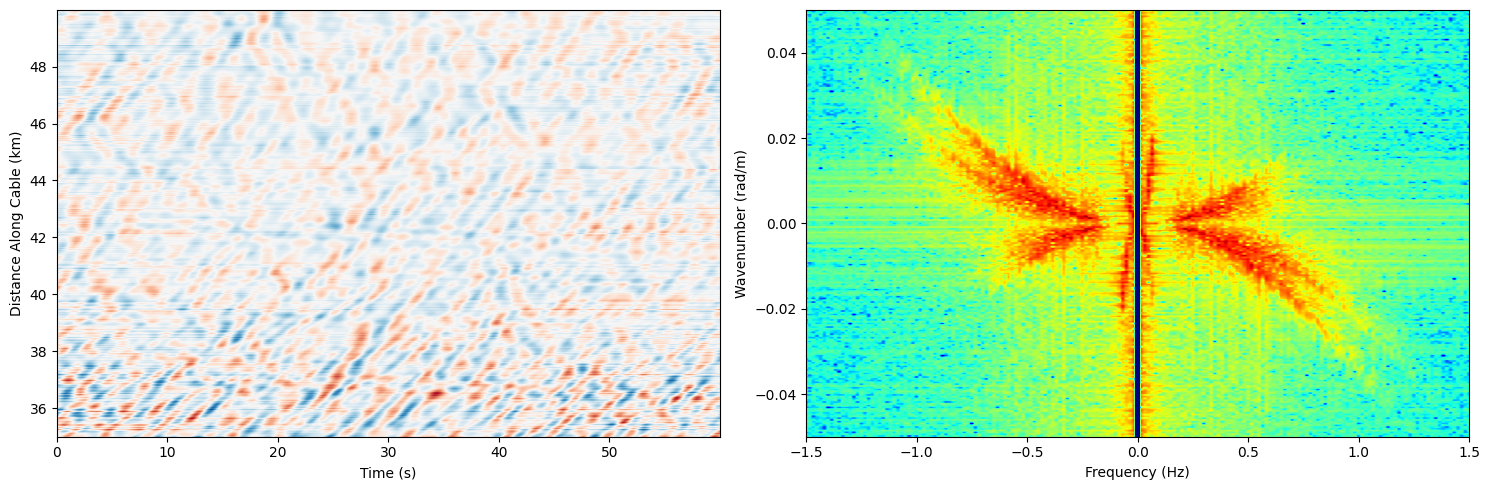

In [10]:
# Plot the data in the time-space domain
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].imshow(strain,origin='lower',extent=[min(time),max(time),min(dist)*0.001,max(dist)*0.001],cmap='RdBu',aspect='auto')
ax[0].set_ylabel('Distance Along Cable (km)')
ax[0].set_xlabel('Time (s)')

# Plot the frequency-wavenumber spectrum
climits = [-240, -140];
cmap = plt.get_cmap('jet')

im = ax[1].imshow(strain_ft,origin='lower',extent=[min(f),max(f),min(k),max(k)],vmin=climits[0],vmax=climits[1],cmap=cmap,aspect='auto')
# plt.colorbar(im,ax=ax[1])

ax[1].set_xlim([-1.5,1.5])
ax[1].set_ylim([-0.05,0.05])
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Wavenumber (rad/m)')
plt.tight_layout()

<br>
The wavenumber-frequency spectrum reveals some very noticeable parabolic structures. This suggests that the propagated energy we're seeing might be due to dispersive wave. The first suspect then might be surface gravity water waves (i.e., your typical "ocean wave"). Surface gravity waves are [known to have a quadratic dispersion relation](https://en.wikipedia.org/wiki/Dispersion_(water_waves)#Frequency_dispersion_for_surface_gravity_waves) of the form:

\begin{equation}
    \omega^2 = gk
\end{equation}

where $\omega$ and $k$ are the angular temporal frequency and wavenumber of a surface wave, respectively. $g$ is the acceleration due to gravity (9.81 m/s).

We can plot this theoretical dispersion curve on top of our data and chek for agreement.
<br><br>


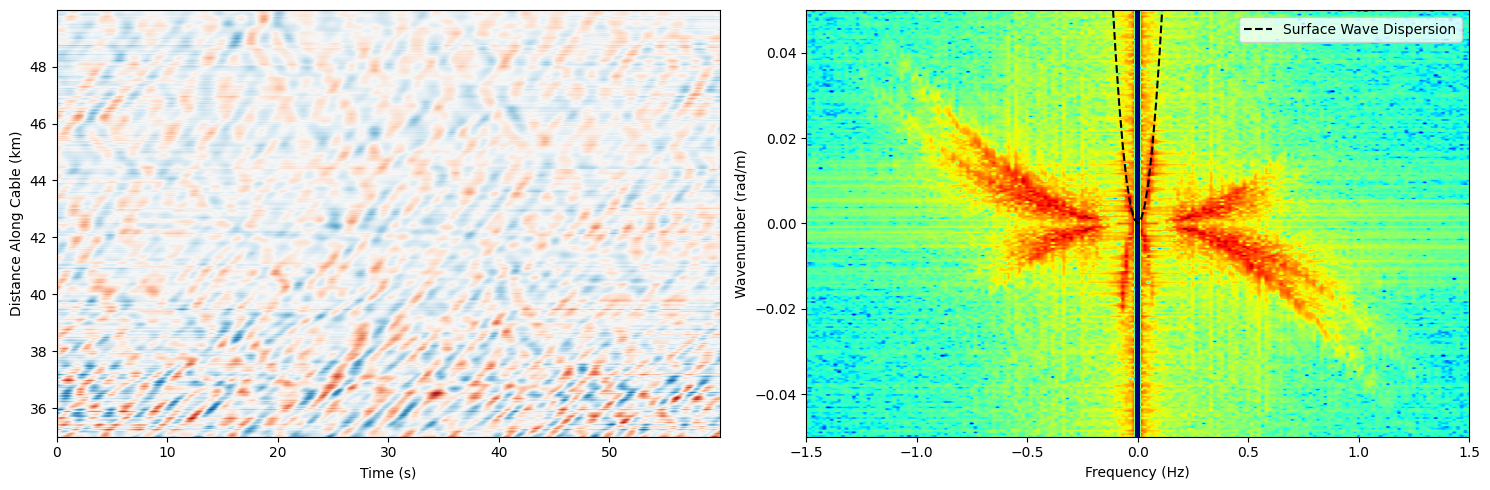

In [11]:
# Plot the data in the time-space domain
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].imshow(strain,origin='lower',extent=[min(time),max(time),min(dist)*0.001,max(dist)*0.001],cmap='RdBu',aspect='auto')
ax[0].set_ylabel('Distance Along Cable (km)')
ax[0].set_xlabel('Time (s)')

# Plot the frequency-wavenumber spectrum
climits = [-240, -140];
cmap = plt.get_cmap('jet')

im = ax[1].imshow(strain_ft,origin='lower',extent=[min(f),max(f),min(k),max(k)],vmin=climits[0],vmax=climits[1],cmap=cmap,aspect='auto')
# plt.colorbar(im,ax=ax[1])

ax[1].set_xlim([-1.5,1.5])
ax[1].set_ylim([-0.05,0.05])
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Wavenumber (rad/m)')
plt.tight_layout()


# Append theoretical surface wave dispersion curve
g = 9.81 # gravitational acceleration (m/s^2)
ax[1].plot(f,((2*np.pi*f)**2)/g,'k--',linewidth=1.5,label='Surface Wave Dispersion')
ax[1].legend()

<br>

There's clearly very strong agreement between the theoretical surface gravity wave dispersion relation and the "thinnest" parabola in the wavenumber-frequency plot. This confirms the presence of surface waves in the data.

Of course, there is clearly another set of parabolas with energy at greater frequencies. Since phase velocity is simply $c_p=\omega/k$, these higher frequency waves must travel much faster than the surface gravity waves.

As it turns out, these waves are [Scholte waves](https://en.wikipedia.org/wiki/Scholte_wave) which propagate at the interface of a fluid (water) and an elastic solid (seabed). The dispersion relation for Scholte waves is more involved that surface gravity waves and beyond the scope of this tutorial, however we can still make some inferences based on the data we have.

But before that, out wavenumber-frequency plot can exhibits strong horizontal and vertical artifacts due to sidelobes from the Fourier transform (which themselves are due to the fact that we have samples over a finite range of time and space). We can clean up our image by applying a __window__ in both the space and time axes which tapers our data array at the edges (e.g. makes it smoother). This will allow us to reduce the sidelobe artifacts at the cost of some frequency/wavenumber resolution. This procedure is known as [windowing](https://en.wikipedia.org/wiki/Window_function) (or _apodization_ if you're fancy) and is extremely common throughout acoustics and signal processing more generally.  

<br>

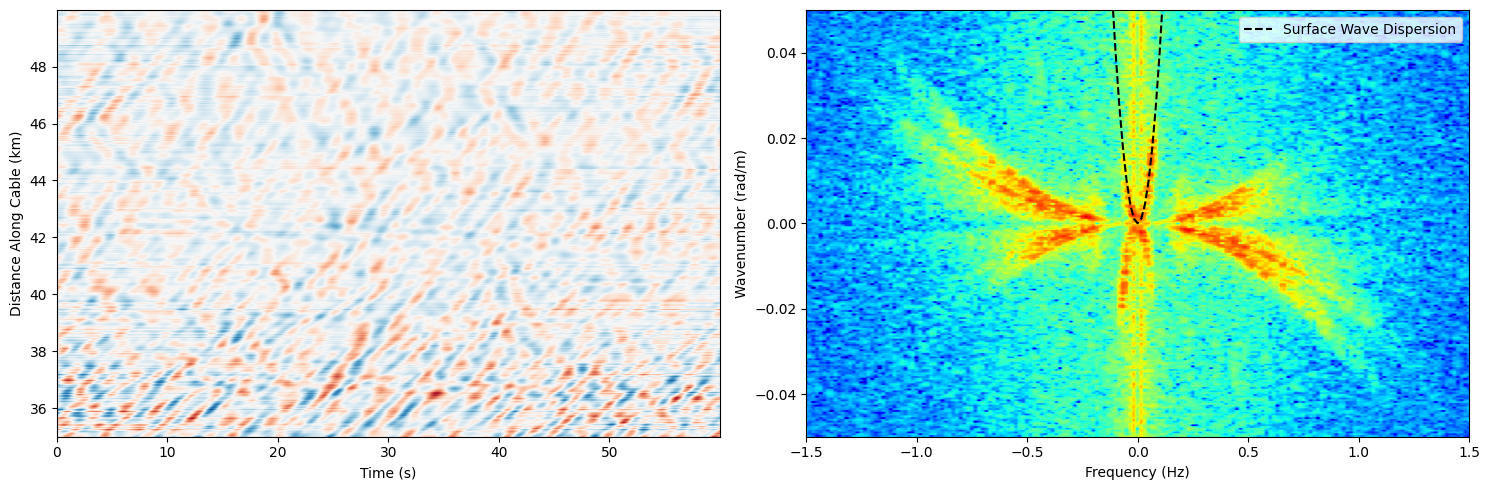

In [12]:
strain = das['Strain'][xmin_idx:xmax_idx:delx,tmin_idx:tmax_idx:delt]

# Detrend the mean value from each channel
strain = sp.detrend(strain,axis=1, type='constant')



###########################################################################################################
# Apply a 2D windowing function to reduce sidelobes and obtain a sharper image
# win = np.outer(sp.windows.boxcar(Nx),sp.windows.boxcar(Nt));
# win = np.outer(sp.windows.hann(Nx),sp.windows.hann(Nt));
win = np.outer(sp.windows.hamming(Nx),sp.windows.hamming(Nt));

# Compute the frequency-wavenumber spectrum
strain_ft = np.fft.fftshift(np.fft.fft2(strain * win))
strain_ft = strain_ft * np.sqrt(1/((samplerate_time*Nt)*(samplerate_time*Nx)))
strain_ft = 20*np.log10(abs(strain_ft))
###########################################################################################################



# Plot the data in the time-space domain
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].imshow(strain,origin='lower',extent=[min(time),max(time),min(dist)*0.001,max(dist)*0.001],cmap='RdBu',aspect='auto')
ax[0].set_ylabel('Distance Along Cable (km)')
ax[0].set_xlabel('Time (s)')

# Plot the frequency-wavenumber spectrum
im = ax[1].imshow(strain_ft,origin='lower',extent=[min(f),max(f),min(k),max(k)],cmap=cmap,vmin=climits[0],vmax=climits[1],aspect='auto')
# plt.colorbar(im,ax=ax[1])

ax[1].set_xlim([-1.5,1.5])
ax[1].set_ylim([-0.05,0.05])
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Wavenumber (rad/m)')
plt.tight_layout()

# Append theoretical surface wave dispersion curve
g = 9.81 # gravitational acceleration (m/s^2)
ax[1].plot(f,((2*np.pi*f)**2)/g,'k--',linewidth=1.5,label='Surface Wave Dispersion')
ax[1].legend()

<br>

Next, we'll can selectively focus our attention on either the _low-frequency_ surface waves or the _high-frequency_ Scholte waves by applying a linear filter (either lowpass or highpass, respectively).

<br>

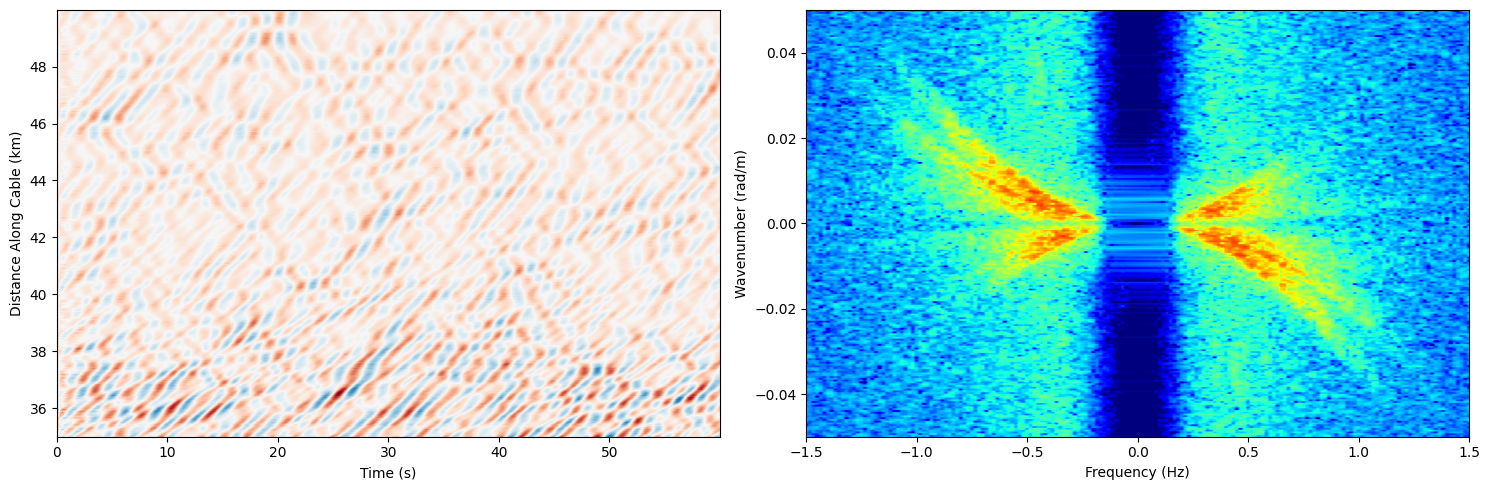

In [13]:
strain = das['Strain'][xmin_idx:xmax_idx:delx,tmin_idx:tmax_idx:delt]

# Detrend the mean value from each channel
strain = sp.detrend(strain,axis=1, type='constant')



###########################################################################################################
# Apply a highpass/lowpass filter tofocus on the Scholte waves/surface gravity waves
b,a = sp.butter(5,0.3,fs=samplerate_time,btype='high')       # Filters out low-frequency surface waves
# b,a = sp.butter(5,0.07,fs=samplerate_time,btype='low')       # Filters out higher-frequency Scholte waves
strain = sp.lfilter(b,a,strain,axis=1)
###########################################################################################################



# Apply a 2D windowing function to reduce sidelobes and obtain a sharper image
# win = np.outer(sp.windows.boxcar(Nx),sp.windows.boxcar(Nt));
# win = np.outer(sp.windows.hann(Nx),sp.windows.hann(Nt));
win = np.outer(sp.windows.hamming(Nx),sp.windows.hamming(Nt));

# Compute the frequency-wavenumber spectrum
strain_ft = np.fft.fftshift(np.fft.fft2(strain * win))
strain_ft = strain_ft * np.sqrt(1/((samplerate_time*Nt)*(samplerate_time*Nx)))
strain_ft = 20*np.log10(abs(strain_ft))

# Plot the data in the time-space domain
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].imshow(strain,origin='lower',extent=[min(time),max(time),min(dist)*0.001,max(dist)*0.001],cmap='RdBu',aspect='auto')
ax[0].set_ylabel('Distance Along Cable (km)')
ax[0].set_xlabel('Time (s)')

# Plot the frequency-wavenumber spectrum
im = ax[1].imshow(strain_ft,origin='lower',extent=[min(f),max(f),min(k),max(k)],cmap=cmap,vmin=climits[0],vmax=climits[1],aspect='auto')
# plt.colorbar(im,ax=ax[1])

ax[1].set_xlim([-1.5,1.5])
ax[1].set_ylim([-0.05,0.05])
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Wavenumber (rad/m)')
plt.tight_layout()

<br>

If we limit our view to positive temporal frequencies (the right half of the wavenumber-frequency spectrum) we see that the energy along the dispersion curves is asymmetric in wavenumber (i.e., the surface waves show more red for positive wavenumbers and the Scholte waves show more red for negative wavenumbers). In our case this means that the surface waves are primarily propagating down the array (_away_ from the coast) and the Scholte waves are primarily propagating up the array (_toward_ the coast, although the Scholte waves are generally more symmetric and the "multiple" parabolas likely correspond to multiple Scholte waves impinging on the array from different, nearly discrete, directions).

<br>

### Comparing our results to other data sources

We've observed that the ambient energy measured on the DAS system is primarily generated from slower ocean surface waves and faster seismic Scholte waves. We can compare this claim against data collected/modeled in the same area, at the same time, but from independent sources.

We'll look at two data sources:
* [HYCOM](https://www.hycom.org/dataserver/gofs-3pt1/analysis) Currents (modeled forecast of ocean surface currents)
* [NDBC Buoy](https://www.ndbc.noaa.gov/) data (measured wave action recorded on a moored buoy near the DAS cable)

But before looking at either of those sources, first we'll ingest some data from the [GEBCO](https://www.gebco.net/) bathymetric database which will help provide context and make our geographic plots look prettier. GEBCO provides a publically accessible gridded global database of ocean (and land) bathymetry. The database can be downloaded from [here](https://www.gebco.net/data_and_products/gridded_bathymetry_data/#global) in a convenient NetCDF format (almost equivalent to HDF5). The database is ~7 GB so to avoid including it in this repo, we've saved out the regional bathymetry to include in this repo and the following commented code is provided for you to use if you choose to download the GEBCO database (make sure to choose the NetCDF format)!

<br>


In [14]:
# Extract bathymetry from GEBCO (to run this section you would need to download the GEBCO bathymetric database to you local system)

# # Load in GEBCO database
# gebco_filename = './wherever_you_store_stuff/GEBCO/GEBCO_2021_sub_ice_topo.nc'
# gebco_file = h5py.File(gebco_filename,'r')

# # Print out the GEBCO bathymetry variables
# print(gebco_file.keys())


# # Extract regional bathymetry from GEBCO database
# lat_lims = [43, 47]
# lon_lims = [-126, -123]

# lat = np.array(gebco_file['lat'])
# lon = np.array(gebco_file['lon'])

# latmin_idx = (np.abs(lat - lat_lims[0])).argmin()
# latmax_idx = (np.abs(lat - lat_lims[1])).argmin()
# lonmin_idx = (np.abs(lon - lon_lims[0])).argmin()
# lonmax_idx = (np.abs(lon - lon_lims[1])).argmin()

# elev_dataset = gebco_file['elevation']

# bathy = {
#     'Latitude': lat[latmin_idx:latmax_idx],
#     'Longitude': lon[lonmin_idx:lonmax_idx],
#     'Elevation': np.array(elev_dataset[latmin_idx:latmax_idx,lonmin_idx:lonmax_idx])
# }

# # Save bathymetry data locally (this is what was done to save the regional bathymetry for this tutorial)
# with open('bathymetry.pkl', 'wb') as f:
#    pickle.dump(bathy, f)

In [15]:
# Load in pre-saved bathymetry (to avoid packaging all of the GEBCO database)

# Pickle is a common python package for saving/loading workspaces and can even play with MATLAB (to an extent).
with open('bathymetry.pkl', 'rb') as f:
    bathy = pickle.load(f)

# Here we print the variable stored within our pre-saved bathymetry dictionary.
# Note we simply have latitude, longitude, and elevation (which is a 2D array)
print(bathy.keys())

dict_keys(['Latitude', 'Longitude', 'Elevation'])


<br>

Next we'll load in the approximate geometry of the Optasense DAS system that we've been analyzing. This information is source from the same OOI directory where we got the data, [here](http://piweb.ooirsn.uw.edu/das/processed/metadata/Geometry/OOI_RCA_DAS_channel_location/).

Since this is a small amount of data it's stored as a simple, human-readable, two-column text file. We can use the `pandas` library to easily ingest the data and then use `numpy` to convert it into a two-column array.

<br>

In [16]:
# Import Optasense array geometry
das_geom_filename = './north_cable_latlon.txt'
das_geom = np.array(pd.read_csv(das_geom_filename,sep=' '))

print(das_geom)

[[  45.20057167 -123.97847167]
 [  45.19941667 -123.98603333]
 [  45.199375   -123.98627   ]
 [  45.19869667 -123.99007333]
 [  45.195385   -124.01011333]
 [  45.19275167 -124.02786167]
 [  45.19267333 -124.02910667]
 [  45.19267333 -124.02910667]
 [  45.19269    -124.02944833]
 [  45.193055   -124.03667167]
 [  45.19515    -124.04780667]
 [  45.19569167 -124.05722333]
 [  45.19617833 -124.06567667]
 [  45.19717667 -124.09916333]
 [  45.19571    -124.128925  ]
 [  45.192705   -124.18994667]
 [  45.19467333 -124.22043167]
 [  45.20250167 -124.25394833]
 [  45.207515   -124.27271167]
 [  45.210065   -124.28225333]
 [  45.21430167 -124.30148333]
 [  45.21899    -124.33140167]
 [  45.22143833 -124.35273333]
 [  45.23344333 -124.40854833]
 [  45.23995167 -124.452295  ]
 [  45.26432833 -124.56808833]
 [  45.27378167 -124.61301167]
 [  45.27931333 -124.63528833]
 [  45.28053333 -124.65506167]
 [  45.27799833 -124.67528333]
 [  45.271855   -124.69408333]
 [  45.261015   -124.71834167]
 [  45.2

(42.99791666666667, 46.993750000000006)

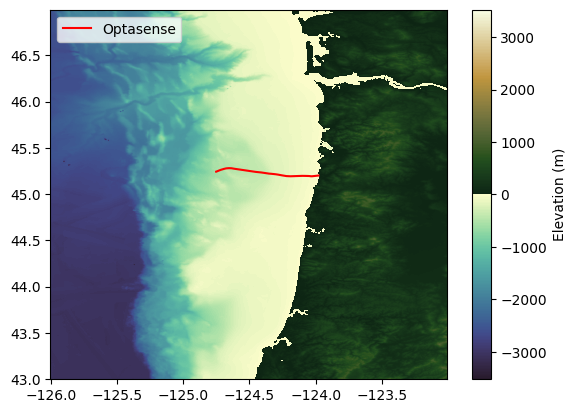

In [17]:
# Plot our own version of the Optasense cable laydown
# Here we use the "topo" colormap from the cmocean library to zhuzh it up a bit).
plt.figure
im = plt.imshow(bathy['Elevation'],extent=[min(bathy['Longitude']),max(bathy['Longitude']),min(bathy['Latitude']),max(bathy['Latitude'])],
                origin='lower',vmin=np.min(bathy['Elevation']),vmax=-np.min(bathy['Elevation']),cmap=cmocean.cm.topo,aspect='auto')
cbar = plt.colorbar(im)
cbar.set_label('Elevation (m)')

# Plot the Optasense cable
plt.plot(das_geom[:,1],das_geom[:,0],'r-',linewidth=1.5,label='Optasense')

plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlim([np.min(bathy['Longitude']),np.max(bathy['Longitude'])])
ax.set_ylim([np.min(bathy['Latitude']),np.max(bathy['Latitude'])])


### HYCOM Currents

[HYCOM](https://www.hycom.org/dataserver/gofs-3pt1/analysis) is a publically available global ocean model that is constantly being computed and assimilated with measured data from buoys, floats, XBT measurements, satellite swaths, etc. to provide consecutive 3-hour forcasts of various ocean parameters. HYCOM produces generates 2D predictions at the ocean surface, as well as 3D predictions as a function of depth.

One such 3D model output are ocean currents. Here, we've already downloaded a HYCOM data file for the region and data coinciding with the DAS data. This file was downloaded using [HYCOM's online data GUI](https://ncss.hycom.org/thredds/ncss/grid/GLBy0.08/expt_93.0/uv3z/2021/dataset.html), although numerous codes exist to pull from HYCOM programatically.

In any case, what we have is a NetCDF file containing multidimensional current data (both North-South and East-West components). This will allow us to plot surface currents in the region of the Optasense cable and see if HYCOM's forecast (from NOV 5, 2021) is consistent with our own findings.

Fortunately, NetCDF files can also be read with the `h5py` library, so the following approach will be similar to earlier in the tutorial.

<br>


In [18]:
# HYCOM currents file
hycom_filename = './uv3z_2021_2.nc4'
hycom_file = h5py.File(hycom_filename,'r')

# Print out the HYCOM variables
print(hycom_file.keys())

currents = {
    'Time': dt.datetime(2000,1,1) + dt.timedelta(hours=hycom_file['time'][0]),
    'Latitude': np.array(hycom_file['lat']),
    'Longitude': np.array(hycom_file['lon'])-360,
    'WaterU': np.squeeze(np.array(hycom_file['water_u'])),
    'WaterV': np.squeeze(np.array(hycom_file['water_v']))
}

# HYCOM contains some "fill" values (particularly at land coordinates) that we'll want to remove for our plots.
currents['WaterU'][currents['WaterU'] == -30000] = 0
currents['WaterV'][currents['WaterV'] == -30000] = 0

<KeysViewHDF5 ['water_u', 'time', 'depth', 'lat', 'lon', 'water_v']>


(42.99791666666667, 46.993750000000006)

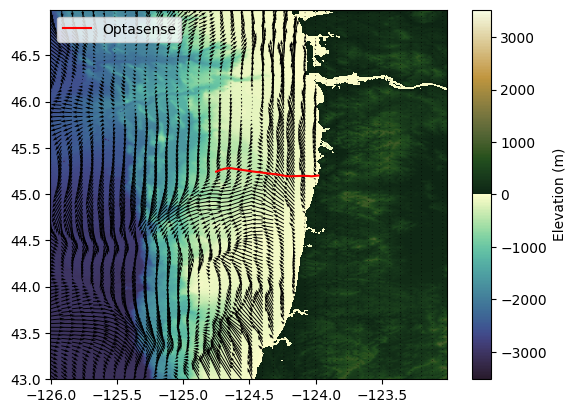

In [19]:
# Plot our own version of the Optasense cable laydown
plt.figure
im = plt.imshow(bathy['Elevation'],extent=[min(bathy['Longitude']),max(bathy['Longitude']),min(bathy['Latitude']),max(bathy['Latitude'])],
                origin='lower',vmin=np.min(bathy['Elevation']),vmax=-np.min(bathy['Elevation']),cmap=cmocean.cm.topo,aspect='auto')
cbar = plt.colorbar(im)
cbar.set_label('Elevation (m)')

# Plot the Optasense cable
plt.plot(das_geom[:,1],das_geom[:,0],'r-',linewidth=1.5,label='Optasense')


######################################################################################################
# Add HYCOM currents this time
plt.quiver(currents['Longitude'],currents['Latitude'],currents['WaterU'],currents['WaterV'],scale=8e3)
######################################################################################################


plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlim([np.min(bathy['Longitude']),np.max(bathy['Longitude'])])
ax.set_ylim([np.min(bathy['Latitude']),np.max(bathy['Latitude'])])


<br>

Nice. From the figure above it appears that the HYCOM forecasted currents generally align with our inference that surface currents are generally directed East-to-West down the cable.

However, HYCOM - though informed by measurements - is only a forecast, much like a weather report. It provides a sanity check but is not strong confirmation. Plus, HYCOM currents are not necessarily indicative of the direction of surface waves, although they often correlate. 

<br>

### NDBC Buoys

The [National Data Buoy Center (NDBC)](https://www.ndbc.noaa.gov/) compiles real measured data from thousands of moored buoys across the globe. Users can use their online tool to find a buoy in a location of interest, then download historical data from it (going back over a decade in some cases).

For our analysis we selected NDBC Buoy 46248, moored north of the Optasense array.

Unlike the DAS datasets, NDBC buoy data are much smalleter in size. Generally around a dozen ocean climatoglogical metrics are measured and saved ever ten minutes which results in _yearly_ file sizes on the order of single-digit Megabytes (compare to 800 MB for 1 minute of DAS data). As such NDBC data are available as text files that are easily imported into python using `pandas` and `numpy` (as with the DAS geometry file).

The exact datafile used here can be found at [this NDBC page](https://www.ndbc.noaa.gov/station_history.php?station=46248).

We are particularly interested in wave direction recorded at the buoy. We will also look at significant wave height (a measure of how strong the surface waves are).

<br>

In [26]:
# NDBC Buoy 46248
ndbc_filename = './46248h2021.txt'
ndbc_data = np.array(pd.read_csv(ndbc_filename,sep='\\s+',skiprows=[0,1]))

# Print out the first row of data. The first value is the yearm then month, day, hour, etc...
print(ndbc_data[0,:])

[2.0210e+03 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+01 2.2000e+02
 9.3000e+00 1.2100e+01 9.9000e+01 9.9000e+01 9.9000e+01 9.9900e+02
 1.0068e+03 1.2300e+01 1.0700e+01 1.2000e+01 9.9000e+01 9.9000e+01]


In [27]:
# Downsample the data (originally at 10-min intervals) to get hourly intervals
# This is useful because significant wave height is only recorded at the top of each hour (only 1 of every 6 values is populated).
ndbc_data = ndbc_data[5::6,:]

# Convert dates from each line of the NDBC data file
ndbc_dates = []
for inc in range(len(ndbc_data)):
    ndbc_dates.append(dt.datetime(int(ndbc_data[inc,0]),int(ndbc_data[inc,1]),int(ndbc_data[inc,2]),int(ndbc_data[inc,3]),int(ndbc_data[inc,4]),0))

# Aggregate some of the NDBC buoy data into a dictionary
# The 
ndbc = {
    'BuoyNumber': 46248,
    'Latitude': 46.248,
    'Longitude': -124.640,
    'Date': ndbc_dates,
    'WaveDirection': ndbc_data[:,5],
    'SignificantWaveHeight': ndbc_data[:,8]
}

<br>

Next we'll determine find the index of the NDBC datetime that is closest to the DAS data, then use it to get a wave direction for to plot.

<br>

In [28]:
# Get the first datetime from the DAS data, to find the index of the closest NDBC buoy time
das_datetime = das_file['Acquisition']['Raw[0]']['RawDataTime']
das_datetime = dt.datetime.fromtimestamp(das_datetime[0]*1e-6,dt.UTC)   # Datetime for the first DAS sample

# Compute index of closest NDBC buoy
nearest_buoy_time_idx = np.argmin(np.abs(np.array(ndbc['Date'],dtype=np.datetime64) - np.datetime64(das_datetime)))


C:\Users\flynntj1\AppData\Local\Temp\ipykernel_122908\2825799490.py:6: UserWarning: no explicit representation of timezones available for np.datetime64
  nearest_buoy_time_idx = np.argmin(np.abs(np.array(ndbc['Date'],dtype=np.datetime64) - np.datetime64(das_datetime)))


(42.99791666666667, 46.993750000000006)

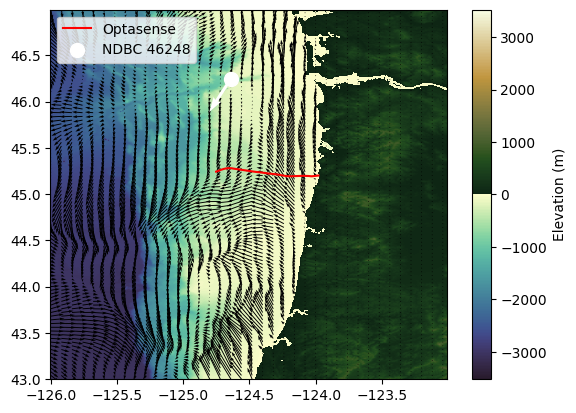

In [29]:
plt.figure
im = plt.imshow(bathy['Elevation'],extent=[min(bathy['Longitude']),max(bathy['Longitude']),min(bathy['Latitude']),max(bathy['Latitude'])],
                origin='lower',vmin=np.min(bathy['Elevation']),vmax=-np.min(bathy['Elevation']),cmap=cmocean.cm.topo,aspect='auto')
cbar = plt.colorbar(im)
cbar.set_label('Elevation (m)')

plt.plot(das_geom[:,1],das_geom[:,0],'r-',linewidth=1.5,label='Optasense')

plt.quiver(currents['Longitude'],currents['Latitude'],currents['WaterU'],currents['WaterV'],scale=8e3)

# Add NDBC Buoy Wave Direction this time
plt.quiver(ndbc['Longitude'],ndbc['Latitude'],\
           np.cos(np.deg2rad(ndbc['WaveDirection'][nearest_buoy_time_idx])),np.sin(np.deg2rad(ndbc['WaveDirection'][nearest_buoy_time_idx])),\
           color='white',scale=10)
plt.scatter(ndbc['Longitude'],ndbc['Latitude'],color='white',s=100,label=f'NDBC {ndbc['BuoyNumber']}')

plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlim([np.min(bathy['Longitude']),np.max(bathy['Longitude'])])
ax.set_ylim([np.min(bathy['Latitude']),np.max(bathy['Latitude'])])


<br>

Great! The NDBC buoy indicates a surface wave direction that is generally toward the southwest. This is in reasonable agreement with our inference that the surface waves picked up by the DAS system were predominantly propagating to the west.

Ultimately, this isn't incontrovertable evidence for our initial claim, but it is supportive. To further investigate this we might consider looking at additional DAS data snippets, looking at additional sections of the same cable, analyzing the South cable, or pursuing additional source of comparitive data.  

Lastly, since we have a year's worth of NDBC buoy data loaded up, we can generate a scatter plot of significant wave height vs wave direction and see if the data point we drew is an outlier or an inlier (is that a word?)

<br>

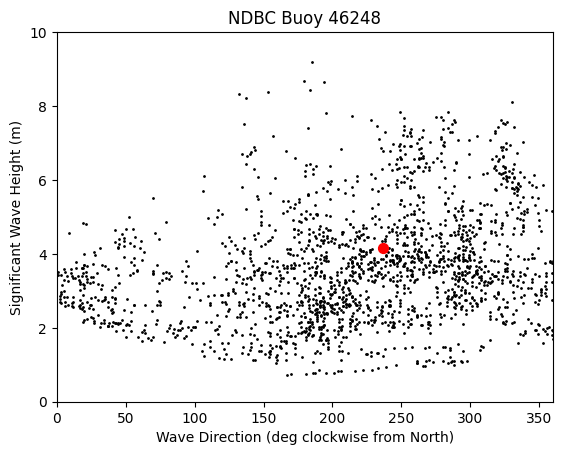

In [30]:
# Plot Significant Wave Height vs Wave Direction
plt.figure
plt.scatter(ndbc['WaveDirection'],ndbc['SignificantWaveHeight'],s=1,color='black')
ax = plt.gca()
ax.set_xlim([0,360])
ax.set_ylim([0,10])
ax.set_xlabel('Wave Direction (deg clockwise from North)')
ax.set_ylabel('Significant Wave Height (m)')
plt.title(f'NDBC Buoy {ndbc['BuoyNumber']}')


# Highlight the time closest to the DAS data
plt.scatter(ndbc['WaveDirection'][nearest_buoy_time_idx],ndbc['SignificantWaveHeight'][nearest_buoy_time_idx],s=50,color='red')

<br>

As we can see, our data point lies well within the cloud of all measurements on NDBC Buoy 46248. Moreover, the prevailing wave direction for this buoy is roughly southwest, with greater significant wave heights (stronger waves) in the due-west direction.

<br>